# Create Spectrograms From EEG Files

In this notebook, we create three different types of spectrograms from EEG files: standard STFT spectrograms, MEL spectrograms, and CWT spectrograms.

Like the spectrograms provided by Kaggle, our spectrograms will be constructed from the chains of the [bipolar double banana EEG montage](https://www.learningeeg.com/montages-and-technical-components). In addition to the temporal and parasagittal chain in the Kaggle spectrograms, we will also include the central chain.

![Chains of the double banana montage](https://uploads-ssl.webflow.com/5e2b590ca27de6be81c64780/5e8ad2dca6b2c1434cac8025_Double_Banana_Setup_(flat)-17-p-1080.png)

We'll take the difference between each electrode pair in these chains, create and add the spectrograms for each pair, and take the average across all pairs to create a final spectrogram for each channel. The following format will be used:

- Left temporal: `LL Spec = mean[(spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1)]`
- Left parasagittal: `LP Spec = mean[(spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1)]`
- Right temporal: `RL Spec = mean[(spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2)]`
- Right parasagittal: `RP Spec = mean[(spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2)]`
- Central: `CZ Spec = mean[(spec(Fz - Cz) + spec(Cz - Pz)]`

For each EEG ID in the train set, we take create 1 spectrogram from the middle 50 seconds. We don't want to use more information than 50 seconds, because during test inference, we only have access to 50 seconds of EEG for each test sample.

Each EEG is converted to a tensor of size `[128, 256, 5]`, where 128 is the number of frequency bins, 256 is the number of time bins, and 5 is the number of channels (LL, LP, RL, RP, CZ).
The width (256) and height (128) of the spectrogram images are chosen to be a multiple of 32, which is a common requirement for convolutional neural networks. Furthermore, 128 x 256 match the dimensions of the spectrograms provided by Kaggle (100x300) as closely as possible.

Furthermore, the values in each spectrogram are normalized to be between -1 and 1.

In [1]:
import os
import sys
import warnings

if bool(os.environ.get("KAGGLE_URL_BASE", "")):
  # running on kaggle
  sys.path.insert(0, "/kaggle/input/hsm-source-files")
else:
  # running locally
  sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src.utils.utils import get_raw_data_dir, get_processed_data_dir, set_seeds
from src.utils.eeg_spectrogram_creator import EEGSpectrogramGenerator
from src.utils.utils import load_middle_50_seconds_of_eeg

from tqdm import tqdm

set_seeds(42)

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

2025-12-29 10:48:02,541 :: root :: INFO :: Initialising Utils
2025-12-29 10:48:02,992 :: root :: INFO :: Initialising Datasets
2025-12-29 10:48:03,269 :: root :: INFO :: Initialising Models
/home/david/miniconda3/envs/aicomp/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/david/miniconda3/envs/aicomp/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which ha

In [2]:
DATA_PATH = get_raw_data_dir()
print("Data path:", DATA_PATH)

SAVE_PATH = get_processed_data_dir() / "eeg_spectrograms"
TRAIN_SAVE_PATH = SAVE_PATH / "train"

train_df = pd.read_csv(DATA_PATH / "train.csv")
train_eeg_ids = train_df["eeg_id"].unique()

Data path: /home/david/git/aicomp/data


In [3]:
spectrogram_types = ["mel", "stft", "cwt"]
spectrogram_creator = EEGSpectrogramGenerator(spectrogram_types)

for type in spectrogram_types:
  type_save_path = TRAIN_SAVE_PATH / type
  type_save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
for i, eeg_id in enumerate(tqdm(train_eeg_ids)):
  eeg = load_middle_50_seconds_of_eeg(DATA_PATH / "train_eegs", eeg_id)
  spectrograms = spectrogram_creator.generate(eeg)

  for spectrogram_type, spectrogram in spectrograms.items():
    out_path = TRAIN_SAVE_PATH / spectrogram_type / f"{eeg_id}.npy"
    np.save(out_path, spectrogram)

In [5]:
def visualize_spectrogram(eeg_id, spectrogram_type):
  example_spectrogram_path = TRAIN_SAVE_PATH / spectrogram_type / f"{eeg_id}.npy"
  example_spectrogram = np.load(example_spectrogram_path)
  print("Example spectrogram shape:", example_spectrogram.shape)
  print(f"Min value: {example_spectrogram.min()}, Max value: {example_spectrogram.max()}")

  fig, axs = plt.subplots(3, 2, figsize=(12, 10))
  fig.suptitle(f"Example {spectrogram_type} Spectrogram for EEG ID: {eeg_id}")
  for i in range(len(spectrogram_creator.chain_names)):
      ax = axs.flat[i]
      ax.imshow(example_spectrogram[:, :, i], origin='lower')
      ax.set_title(f'Channel {spectrogram_creator.chain_names[i]}')

Example spectrogram shape: (128, 256, 5)
Min value: -0.8136080503463745, Max value: 0.9950472712516785
Example spectrogram shape: (128, 256, 5)
Min value: -0.8333665132522583, Max value: 0.9950249791145325
Example spectrogram shape: (128, 256, 5)
Min value: -0.6220259666442871, Max value: 0.9686462879180908


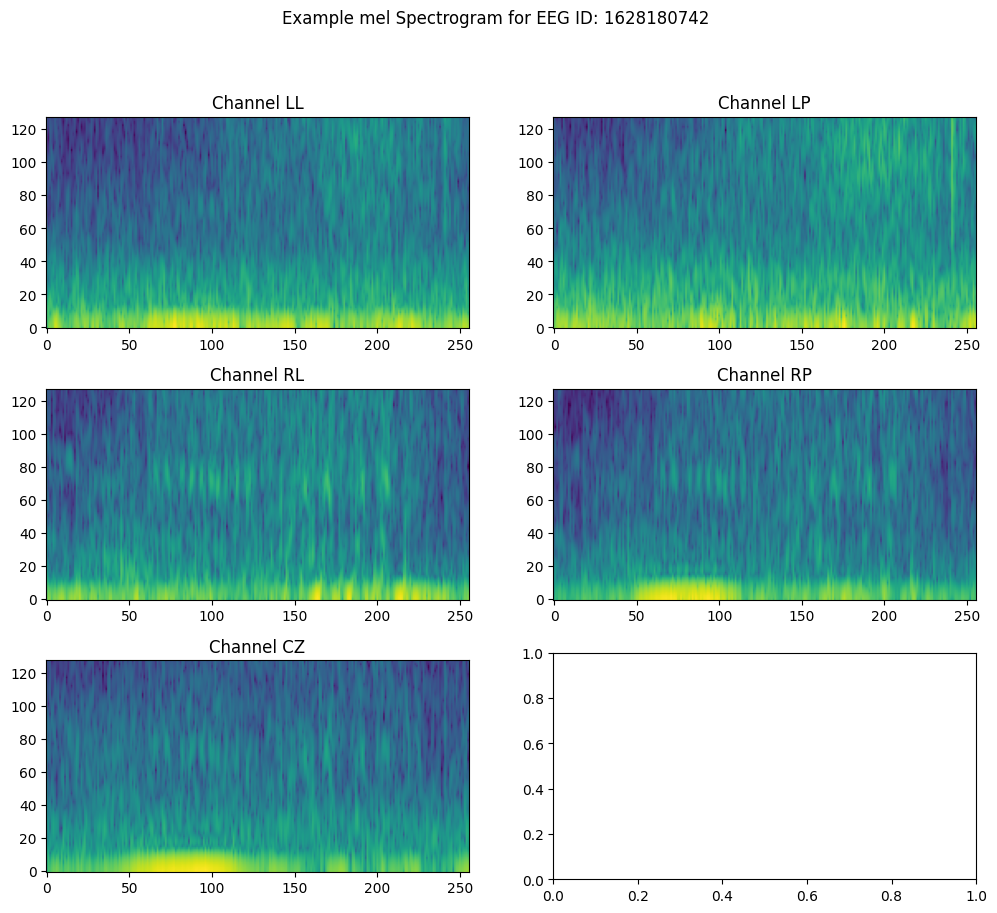

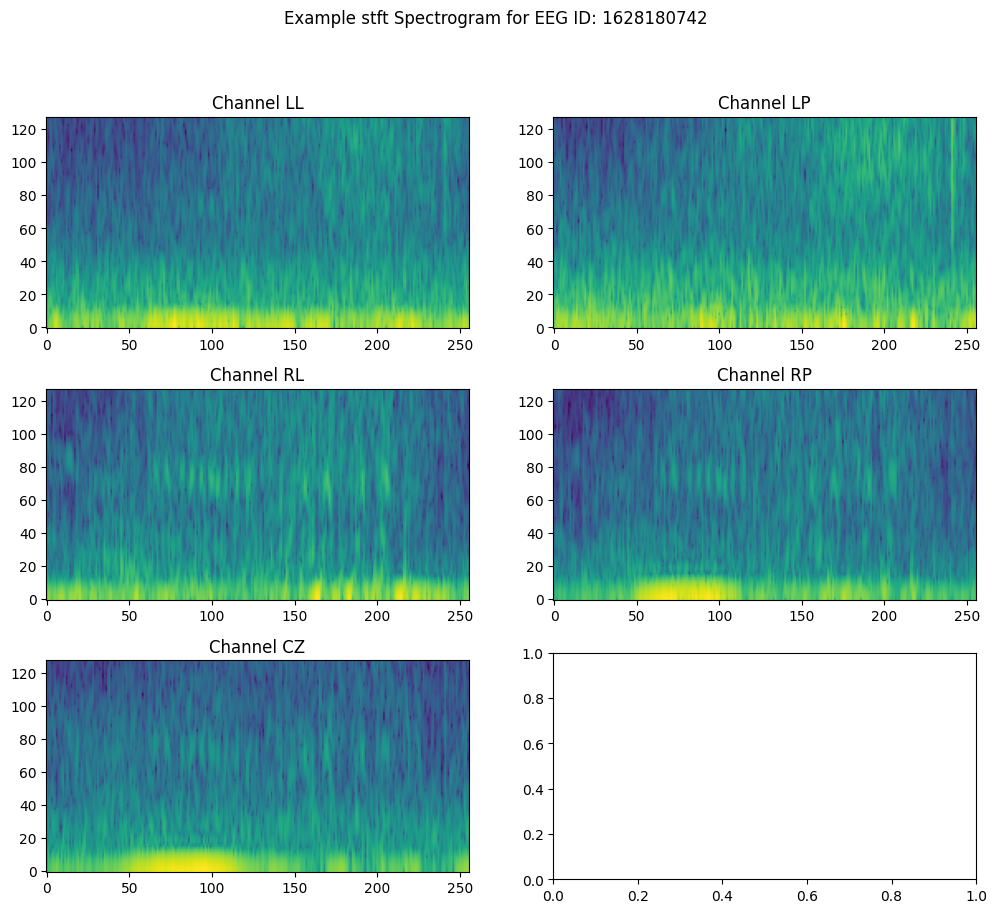

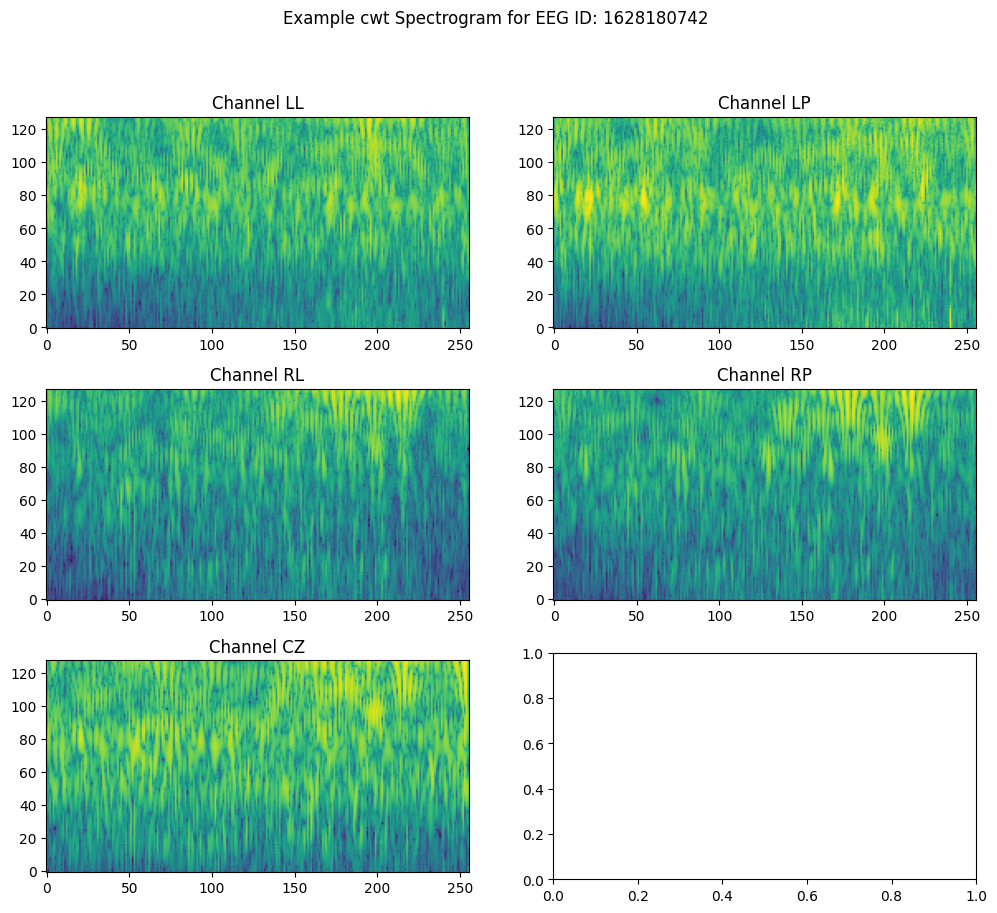

In [6]:
eeg_id = train_eeg_ids[0]
visualize_spectrogram(eeg_id=eeg_id, spectrogram_type="mel")
visualize_spectrogram(eeg_id=eeg_id, spectrogram_type="stft")
visualize_spectrogram(eeg_id=eeg_id, spectrogram_type="cwt")